# Trend following strategy in futures using Time Series Momentum (TSMOM) and Continuous forecasts (CF)

Prepared by: Jirong Huang
jironghuang88@gmail.com

# 0. Executive summary

Before June 2010, across different configuration of trend following strategies, trend following strategies perform well with sharpe of > 1, high calmar ratio, reasonable drawdowns.

After June 2010, risk adjusted returns, sharpe ratio dropped off signficantly with peformance dropping to below 0.7 for both strategies. 

Despite the deterioration in performance of trend following strategies, it may still have a place in an investor’s portfolio. According to Kathryn Kaminski, chief investment strategist at AlphaSimplex group and Visiting Lecturer in Finance at the MIT Sloan School of Management mentioned that trend following exhibits a crisis alpha characteristic. She studied 800 years of crisis and found that all crises create trends and there are opportunities for divergent strategies.

# 1. Project motivation

As David Ricardo, a British economist in the 19th century once said, ‘cut short your losses and let your profits trend’ allude to the point that trend following as a profitable strategy could exist even back then.

Having read AQR’s papers on the Time Series Momentum (TSMOM, I am keen to explore this topic in the futures space (Moskowitz, T. J., Ooi, Y. H., & Pedersen, L. H. (2012)). Besides AQR papers, I have also followed closely the work of Robert Carver, an ex-MAN AHL quant who specialized in the space of intermediate to long term trend-following futures strategies. 

In this study, I will be exploring 2 approaches,

i.) TSMOM approach developed by AQR
ii.) Continuous forecasts approach (loosely based on Robert Carver’s framework in his books Leveraged Trading and Systematic Trading)

*Note: But because of limitations of the dataset that I will be using, I’m unable to incorporate ‘carry roll returns forecasts’ in Robert Carver’s books. I believe this would have impact on the effectiveness of the strategy.

The performance of strategies will be evaluated across 2 periods,

i.) In-sample period: 1984 to June 2010
ii.) Out-of-sample period: June 2010 to 2016

In [1]:
from futures_research_class import FuturesResearch
import pandas as pd
import numpy as np
import time
import random
import os
import datetime as dt
import yaml
import re
import quandl
import yfinance as yf
import matplotlib.pyplot as plt
import util as ut
import util_futures as uf
from sklearn import datasets, model_selection
from scipy.optimize import minimize, rosen, rosen_der
import json
import multiprocessing as mp
from itertools import product
import pyfolio as pf
import empyrical
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/home/jirong/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
/home/jirong/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
#Initialize strategy class
strategy = FuturesResearch(data_path = "./quantopian_data/futures_incl_2016.csv", 
                           ewmac_variations = [8,16,32,64], 
                           breakout_variations = [40,80,160,320], 
                           optimize_weights_path = './optimize_weights', 
                           forecast_diff_before_rebal = 6.0,
                           notion_capital_per_position = 20000,
                           fix_capital = 500000,
                           commission = 20,
                           boostrap_sample_size = 300,
                           num_samples_per_period = 25,
                           prop_block_boostrap = 0.25,
                           max_annual_volatility = 0.15,
                           ind_instr_ref_volatility = 0.4                         
                           )  

# 2. Dataset

For this study, I will be using Futures dataset across 4 asset classes: Indices, Bonds, Currencies, Commodites provided by Quantopian up till 2016. The continuous dataset is presumably stiched through backward, forward or proportional adjusted methodology (not explicitly mentioned in Quantopian’s github repository).

Below is the descriptive statistics on 50 instruments used in this study.

In [3]:
#Extracted descriptive statistics code from Quantopian github 
#https://github.com/quantopian/research_public/blob/master/advanced_sample_analyses/TSMOM/TS%20MOM.ipynb

res = strategy.returns

std_index = strategy.returns.resample('BM').last().index
mth_index = pd.DataFrame(index=std_index)
mth_index_vol = pd.DataFrame(index=std_index)
summary_stats = pd.DataFrame(index=['Asset', 'Start', 'Mean', 'Std', \
                                    'Skew', 'Kurt', 'Sharpe Ratio'])

for oo in res.columns:
    returns = res[oo]
    returns.dropna(inplace=True)
    
    first_date = returns.index[0].strftime("%Y-%m-%d")   # store this to show when data series starts
    
    ret_index = (1 + returns).cumprod()
    ret_index[0] = 1
    
    # equation (1) ex ante vol estimate
    day_vol = returns.ewm(ignore_na=False,
                          adjust=True,
                          com=60,   
                          min_periods=0).std(bias=False)
    vol = day_vol * np.sqrt(261) # annualise
    
    ret_index = pd.concat([ret_index, vol], axis=1)
    ret_index.columns = [oo, 'vol']
    
    # convert to monthly
    ret_m_index = ret_index.resample('BM').last().ffill()
    ret_m_index.ix[0][oo] = 1

    mth_index = pd.concat([mth_index, ret_m_index[oo]], axis=1)
    tmp = ret_m_index['vol']
    tmp.name = oo + "_Vol"
    mth_index_vol = pd.concat([mth_index_vol, tmp], axis=1)

    tmp_mean = ret_index[oo].pct_change().mean()*252
    tmp_std = ret_index[oo].pct_change().std()*np.sqrt(252)
    tmp_skew = ret_index[oo].pct_change().skew()
    tmp_kurt = ret_index[oo].pct_change().kurt()
    sr = tmp_mean / tmp_std

    dict = {'Asset': oo,
            'Start': first_date,
            'Mean': np.round(tmp_mean,4),
            'Std':  np.round(tmp_std,4),
            'Skew': np.round(tmp_skew,4),
            'Kurt': np.round(tmp_kurt,4),
            'Sharpe Ratio': np.round(sr,4),
            }
    summary_stats[oo] = pd.Series(dict)

summary_stats = summary_stats.transpose()
futures_list = pd.read_csv("futures_list.csv")
all = summary_stats.reset_index().merge(futures_list)
all.sort_values(by=["ASSET_CLASS", "FUTURES"], inplace=True)
del all['Asset'], all['index']

all.set_index(['ASSET_CLASS', 'FUTURES']).style.set_properties(**{'text-align': 'right'})

/home/jirong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


# 4. Continuous forecasts methodology

In conventional technical analysis, trade entries and exits are usually binary in nature and current position size is dependent on entry and exit conditions defined t periods ago.

Current position size ~ Entry, exit conditions (dependent on current state) defined t periods ago

But in the financial world, asset returns outcome are continuous in nature with a distribution. And hence it would be optimal for current position size to be directly proportionate to Expected Returns conditional on current forecast, risk capital allocation, current volatility of instrument, overall portfolio volatility, correlation matrix, cost of rebalancing. This reasonates with the Bayesian school of thought

Current position size ~ E(Returns | current forecast, risk capital, current volatility of instrument, overall portfolio volatility, correlation matrix, cost of rebalancing)

The advantage of continuous forecasts approach is that you only need to compare optimal position size given current conditions against current positions. If it diverges by x%, then you rebalance. The risk management layer and position sizing is inherently built into the framework. And it is not dependent on the state of current position. This is different from a binary trading system which is state dependent.

4.1.1. Exponential moving averages

1) Selection of pairs of fast and slow moving averages to reflect different time-frames:  8-32, 16-64, 32-128, 64-254
2) Raw forecast: First, I take the difference between pair of moving averages
3) Risk-adjusted forecast: Next, I divide raw forecast by instrument-risk (volatility of instrument in price unit) to get a risk adjusted forecast. 

4.1.2. Donchian Channels

1) Selection of lookbacks to reflect different time-frames: 40, 80, 160, 320
2) Forecast: Derived by taking difference between current price with middle price (half of max and min over N lookback) divided by difference max and minimum price over N lookback. The formula is as follows,  40 * (P_{t} – R_{middle N}) / (R_{maxN} – R_{minN}). 40 multiplier is applied to scale forecasts up to a range of (-20, 20)

4.1.3. Forecast scalar: Rescaling forecasts to average value of 10 for consistency across instruments and time

1) Absolute median forecasts across instruments within a forecast type (e.g 8-32 exponential moving average forecast) is extracted for each day. 
2) Next, an expanding window is used to compute the average value of median forecasts in point
3) Then, I compute the forecast scalar by dividing average value in point 2 with 10 i.e. we scale the forecast to an average absolute value of 10. 10 represents the average forecast strength for each instrument. In the graphs below, you will notice that forecast scalar plateaus to a more level as more time progresses.

/home/jirong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


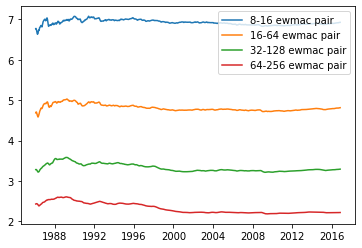

In [4]:
plt.plot(strategy.forecast_ewmac_info[8]['forecast_scalar'], label = '8-16 ewmac pair')
plt.plot(strategy.forecast_ewmac_info[16]['forecast_scalar'], label = '16-64 ewmac pair')
plt.plot(strategy.forecast_ewmac_info[32]['forecast_scalar'], label = '32-128 ewmac pair')
plt.plot(strategy.forecast_ewmac_info[64]['forecast_scalar'], label = '64-256 ewmac pair')
plt.legend(loc="upper right")
plt.show()

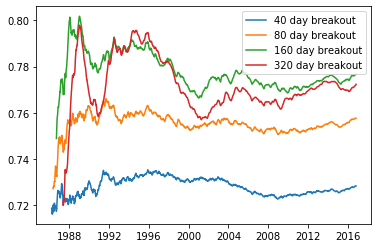

In [5]:
plt.plot(strategy.forecast_breakout_info[40]['forecast_scalar'], label = '40 day breakout')
plt.plot(strategy.forecast_breakout_info[80]['forecast_scalar'], label = '80 day breakout')
plt.plot(strategy.forecast_breakout_info[160]['forecast_scalar'], label = '160 day breakout')
plt.plot(strategy.forecast_breakout_info[320]['forecast_scalar'], label = '320 day breakout')
plt.legend(loc="upper right")
plt.show()

4.1.4. Combining adjusted forecasts into weighted forecast for each instrument

From section 4.1.3, I would obtain adjusted forecasts for each instrument. The next step is to combine the forecasts via weights. In this study, I will be using 2 weighting schemes,

1.) Equal weight

In the first weighting scheme, I assign equal weights to the rules. In my study, I have 8 different forecasts, 4 for exponential moving averages and 4 for Donchian Channels. 12.5% weight is allocated to each of these forecasts.

2.) Weighting through block bootstrapping

In the next weighting scheme, I performed the following steps, 

i. Within the in-sample period, I extract 25 blocks of continuous daily periods. Each period accounts for 25% of available days.


In [6]:
i = 6
strategy.forecast_diff_before_rebal = float(i)     
#Running boostrapped optimized weights here
#strategy.avg_optimized_sharpe_allinstr_single_period(26) #a[6803:6804]  #2010-06-07 

ii. For each instrument, I compute the returns stream, ARit associated with each forecasts. First, similar to TSMOM, I find the leverage, Lit required to bring up the realized volatility, Vol_{it-1} to a reference level of 40%. Next, I scale the leverage up/down according to the strength of the forecasts.

                            $$ARit = 40%/Vol_{it-1} * F_{it} * R_{it}  =  L_{it} * F_{it} * R_{it}$$
                            
iii. Commission costs of 0.1% is also imposed per trade to penalize frequent rebalancing. Rebalancing only occurs when current forecasts differs from last forecasts by X points (In optimization, found to be 6 points at the overall level).
iv. With the derived returns stream, I proceed to find optimal weights, W_{rbi} amongst rules, r for the highest sharpe associated for each boostrapped block, b per instrument, i. 
v. Lastly, I pooled the weights together and find the average optimal weights across instruments for in-sample period,
                                            $$W_{r} = Average_{bi} (W_{rbi})$$
                                            
Note: Applying optimized weights for each instrument is avoided because of relative small number of boostrapped blocks. And based on Robert Carver’s advice, instruments are more likely to be similar than different in their momentum characteristic. That being said, in my next iteration, I could test this hypothesis.                                           

In [7]:
#Construct a data-frame from json file   
wts = strategy.get_all_opt_weights()
col_names = ['ewmac' + str(i) for i in strategy.ewmac_variations] + ['breakout' + str(i) for i in strategy.breakout_variations] 
all_wts = wts[col_names].astype(float)
avg_wts = wts[col_names].astype(float).mean(axis=0)   
print(avg_wts)

ewmac8         0.111069
ewmac16        0.041851
ewmac32        0.063619
ewmac64        0.200274
breakout40     0.281200
breakout80     0.111628
breakout160    0.081539
breakout320    0.108819
dtype: float64


4.1.5. Scaling up or down at portfolio level according to maximum overall portfolio risk allowed

With diversification across the instruments and forecasts, the realized volatility of the portfolio would be significantly lower than the reference annualized volatility of 40% per instrument. In AQR’s study, the annualized volatility averaged around 12%.

For the purpose of this study, I will use a maximum realized volatility cap at 15%. The steps are as follow,

i. Assume forecasts, Ft-1 are at both extreme of -20 and +20 depending on the polarity of the forecasts. And find the maximum realized volatility, Mvt-1

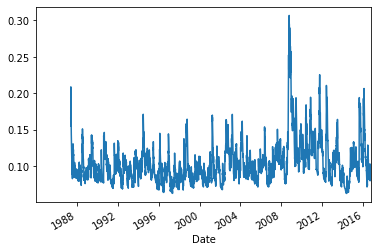

In [8]:
strategy.compute_optimal_leverage_all_instruments()
strategy.full_forecasts_vol.plot()

ii. Next, find the leverage adjustment factor, A_{t} at the portfolio level,
              At = Maximum realized volatility cap of 15% /Mvt-1

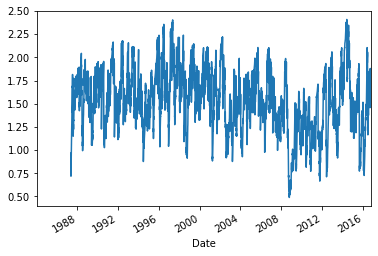

In [9]:
strategy.portf_vol_adj_factor.plot()

* Note that during 2008-2009 crisis, adjustment factor to portfolio dived to 0.50, suggesting that correlation across instruments could have increased.

iii. Last but not the least, I will map the leverage adjustment factor, At to the leverage factor in section 4.1.4 (2ii). The final leverage, FL_{it} for the instrument will be as follows,

                                                   FL_{it} = A_{t} * L_{it}
                                                   
iv. In terms of position sizing, let’s say if instrument is assigned a risk capital of $20,000. The notional capital, NC_{it} to be deployed for this instrument would be

                                                  NC_{it} = FL_{it} * $20,000

Note: An alternative is to consider the correlation matrix between instruments and find the adjustment factor.

# 5. Evaluation of strategies

I tested the following strategies on in-sample (before 2010-06-07) and out-of-sample periods (after 2010-06-06). Below are the different configurations, 

i. TSMOM excluding costs in sample: AQR TSMOM strategy is tested on in sample period excluding costs.
ii. TSMOM including costs in sample: AQR TSMOM strategy is tested on in sample period including costs.
iii. Pre-optimize in sample: Equal weights are allocated to different forecasts. And the strategy is tested on in sample period.
iv. Optimize in sample: Optimized weights based on block boostrapping are allocated to different forecasts. And the strategy is tested on in sample period.
v. Pre-optimize out of  sample: Equal weights are allocated to different forecasts. And the strategy is tested on out of sample period.
vi. Optimize out of sample: Optimized weights based on block boostrapping are allocated to different forecasts. And the strategy is tested on out of sample period.

In [11]:
#Initialize performance data-frame for comparison purposes
column_names = ["strategy", "sharpe", "annualized_returns", "annualized_sd", "max_drawdown", "calmar_ratio"]
performance = pd.DataFrame(columns = column_names)

#Ingest Fama-French 3 factor data
df = pd.read_csv("factors.csv")
df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Year'] = df["Date"].dt.year 
df['Month'] = df["Date"].dt.month 

3. TSMOM methodology

In AQR papers, the authors experimented with fixed lookback periods of 1 year which determines the trading signal for the next month i.e. if price of an asset increase over 1 year period, the trading signal for next month would be long. Reverse holds when price of an asset decreased. Position of each asset is based on lookback exponential standard deviation of daily returns with annualized volatility of 40%.

In [12]:
#################################   
#TSMOM approach (excluding costs)
#################################
ret_stream, ret_stream_costs, avg_ret_stream, avg_ret_stream_costs = strategy.TSMOM_all_instr_returns()    

avg_ret_stream_with_date = avg_ret_stream.copy().to_frame()
avg_ret_stream_costs_with_date = avg_ret_stream_costs.copy().to_frame()

avg_ret_stream_with_date['Date']= pd.to_datetime(avg_ret_stream_with_date.index, format='%Y-%m-%d')
avg_ret_stream_with_date['Year'] = avg_ret_stream_with_date["Date"].dt.year 
avg_ret_stream_with_date['Month'] = avg_ret_stream_with_date["Date"].dt.month
avg_ret_stream_with_date.drop(['Date'], axis=1, inplace = True)

avg_ret_stream_costs_with_date["Date"] = pd.to_datetime(avg_ret_stream_costs_with_date.index, format='%Y-%m-%d')
avg_ret_stream_costs_with_date["Year"] = avg_ret_stream_costs_with_date["Date"].dt.year
avg_ret_stream_costs_with_date["Month"] = avg_ret_stream_costs_with_date["Date"].dt.month
avg_ret_stream_costs_with_date.drop(['Date'], axis=1, inplace = True)

#Performance characteristic of TSMOM excluding costs
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(avg_ret_stream[:'2010-06-07'], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(avg_ret_stream[:'2010-06-07'], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(avg_ret_stream[:'2010-06-07'], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(avg_ret_stream[:'2010-06-07']))
print ("Calmar ratio = ", empyrical.calmar_ratio(avg_ret_stream[:'2010-06-07'], period='monthly'))  

sharpe_tsmom_excl_costs_2010 = empyrical.sharpe_ratio(avg_ret_stream[:'2010-06-07'], period='monthly')    
ret_tsmom_excl_costs_2010 = empyrical.annual_return(avg_ret_stream[:'2010-06-07'], period='monthly')
sd_tsmom_excl_costs_2010 = empyrical.annual_volatility(avg_ret_stream[:'2010-06-07'], period='monthly')    
drawdown_tsmom_excl_costs_2010 = empyrical.max_drawdown(avg_ret_stream[:'2010-06-07'])
calmar_tsmom_excl_costs_2010 = empyrical.calmar_ratio(avg_ret_stream[:'2010-06-07'], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'TSMOM excluding costs', 
                                  'sharpe': sharpe_tsmom_excl_costs_2010,
                                  'annualized_returns': ret_tsmom_excl_costs_2010,
                                  'annualized_sd': sd_tsmom_excl_costs_2010,
                                  'max_drawdown': drawdown_tsmom_excl_costs_2010,
                                  'calmar_ratio': calmar_tsmom_excl_costs_2010
                                  }, ignore_index=True) 

#Comparison (Fama french 3 factor)  
data_tsmom_excl_costs_2010 = pd.merge(avg_ret_stream_with_date, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_tsmom_excl_costs_2010.columns = ['strategy_returns', 'Year', 'Month', 'Date', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_tsmom_excl_costs_2010 = data_tsmom_excl_costs_2010.dropna()

X_tsmom_excl_costs_2010 = data_tsmom_excl_costs_2010[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_tsmom_excl_costs_2010 = sm.add_constant(X_tsmom_excl_costs_2010)
model_tsmom_excl_costs_2010 = sm.OLS(data_tsmom_excl_costs_2010['strategy_returns'].astype(float), X_tsmom_excl_costs_2010).fit()
print(model_tsmom_excl_costs_2010.summary())
    

Annualized Sharpe Ratio =  1.47097113804028
Annualized Mean Returns =  0.17077023790767254
Annualized Standard Deviations =  0.11715011479556907
Max Drawdown =  -0.18878024079038444
Calmar ratio =  0.9045980511132538
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.585
Date:                Fri, 25 Dec 2020   Prob (F-statistic):              0.150
Time:                        11:00:25   Log-Likelihood:                 743.57
No. Observations:                 380   AIC:                            -1473.
Df Residuals:                     373   BIC:                            -1446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                   

/home/jirong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [13]:
##################################################################
#TSMOM approach (including costs)
##################################################################
#Performance characteristic of TSMOM including costs
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(avg_ret_stream_costs[:'2010-06-07'], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(avg_ret_stream_costs[:'2010-06-07'], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(avg_ret_stream_costs[:'2010-06-07'], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(avg_ret_stream_costs[:'2010-06-07']))
print ("Calmar ratio = ", empyrical.calmar_ratio(avg_ret_stream_costs[:'2010-06-07'], period='monthly'))  

sharpe_tsmom_incl_costs_2010 = empyrical.sharpe_ratio(avg_ret_stream_costs[:'2010-06-07'], period='monthly')    
ret_tsmom_incl_costs_2010 = empyrical.annual_return(avg_ret_stream_costs[:'2010-06-07'], period='monthly')
sd_tsmom_incl_costs_2010 = empyrical.annual_volatility(avg_ret_stream_costs[:'2010-06-07'], period='monthly')    
drawdown_tsmom_incl_costs_2010 = empyrical.max_drawdown(avg_ret_stream_costs[:'2010-06-07'])
calmar_tsmom_incl_costs_2010 = empyrical.calmar_ratio(avg_ret_stream_costs[:'2010-06-07'], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'TSMOM including costs', 
                                  'sharpe': sharpe_tsmom_incl_costs_2010,
                                  'annualized_returns': ret_tsmom_incl_costs_2010,
                                  'annualized_sd': sd_tsmom_incl_costs_2010,
                                  'max_drawdown': drawdown_tsmom_incl_costs_2010,
                                  'calmar_ratio': calmar_tsmom_incl_costs_2010
                                  }, ignore_index=True)         

#Comparison (Fama french 3 factor) 
data_tsmom_incl_costs_2010 = pd.merge(avg_ret_stream_costs_with_date, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_tsmom_incl_costs_2010.columns = ['strategy_returns', 'Year', 'Month','Date', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_tsmom_incl_costs_2010 = data_tsmom_incl_costs_2010.dropna()

X_tsmom_incl_costs_2010 = data_tsmom_incl_costs_2010[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_tsmom_incl_costs_2010 = sm.add_constant(X_tsmom_incl_costs_2010)
model_tsmom_incl_costs_2010 = sm.OLS(data_tsmom_incl_costs_2010['strategy_returns'].astype(float), X_tsmom_incl_costs_2010).fit()
print(model_tsmom_incl_costs_2010.summary())

Annualized Sharpe Ratio =  1.368538459925192
Annualized Mean Returns =  0.15754172892117357
Annualized Standard Deviations =  0.11715011479556904
Max Drawdown =  -0.19783663909147559
Calmar ratio =  0.7963223073574835
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.585
Date:                Fri, 25 Dec 2020   Prob (F-statistic):              0.150
Time:                        11:00:35   Log-Likelihood:                 743.57
No. Observations:                 380   AIC:                            -1473.
Df Residuals:                     373   BIC:                            -1446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                  

In [14]:
#######################################Analyze in sample data with rebal param optimization###################################    
#Optimization of rebalancing when forecasts differ by x units
#column_names = ["rebal_parameter", "sharpe", "annualized_returns", "annualized_sd", "max_drawdown", "calmar_ratio"]
#rebal_perf = pd.DataFrame(columns = column_names)

#Before 2010
#for i in range(1, 10):

#    print(i)

#    strategy.forecast_diff_before_rebal = float(i)
#    strategy_returns = strategy.get_all_commod_returns()        
#    portfolio_returns = strategy_returns.mean(axis=1)    
#    sharpe = empyrical.sharpe_ratio(portfolio_returns[:'2010-06-07'], period='daily')    
#    ret = empyrical.annual_return(portfolio_returns[:'2010-06-07'], period='daily')
#    sd = empyrical.annual_volatility(portfolio_returns[:'2010-06-07'], period='daily')    
#    drawdown = empyrical.max_drawdown(portfolio_returns[:'2010-06-07'])
#    calmar = empyrical.calmar_ratio(portfolio_returns[:'2010-06-07'], period='daily')    

#    rebal_perf = rebal_perf.append({'rebal_parameter': i, 
#                                    'sharpe': sharpe,
#                                    'annualized_returns': ret,
#                                    'annualized_sd': sd,
#                                    'max_drawdown': drawdown,
#                                    'calmar_ratio': calmar
#                                    }, ignore_index=True) 

#    rebal_parameter    sharpe  ...  max_drawdown  calmar_ratio
# 0              1.0  0.542778  ...     -0.439715      0.121640
# 1              2.0  0.972041  ...     -0.364766      0.270704
# 2              3.0  1.243172  ...     -0.242046      0.487068
# 3              4.0  0.992539  ...     -0.426455      0.256649
# 4              5.0  1.074776  ...     -0.363417      0.307186
# 5              6.0  1.348111  ...     -0.162601      0.753003
# 6              7.0  1.344817  ...     -0.176449      0.713426
# 7              8.0  1.302024  ...     -0.185460      0.647840
# 8              9.0  1.146320  ...     -0.242839      0.441619

#Strategy returns
i = 6
strategy.forecast_diff_before_rebal = float(i)
strategy_returns = strategy.get_all_commod_returns()        
portfolio_returns_nonopt = strategy_returns.mean(axis=1)
portfolio_monthly_returns_nonopt = empyrical.aggregate_returns(portfolio_returns_nonopt, 'monthly')

#Analyze returns streams
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(portfolio_returns_nonopt[:'2010-06-07'], period='daily'))
print ("Annualized Mean Returns = ", empyrical.annual_return(portfolio_returns_nonopt[:'2010-06-07'], period='daily'))
print ("Annualized Standard Deviations = ", empyrical.max_drawdown(portfolio_returns_nonopt[:'2010-06-07']))    
print ("Max Drawdown = ", empyrical.max_drawdown(portfolio_returns_nonopt[:'2010-06-07']))
print ("Calmar ratio = ", empyrical.calmar_ratio(portfolio_returns_nonopt[:'2010-06-07'], period='daily'))    

portfolio_monthly_returns_insample = empyrical.aggregate_returns(portfolio_returns_nonopt[:'2010-06-07'], 'monthly')    
portfolio_monthly_returns_insample = portfolio_monthly_returns_insample.to_frame()
portfolio_monthly_returns_insample.columns = ['strategy_returns']
portfolio_monthly_returns_insample['Year'] = portfolio_monthly_returns_insample.index.get_level_values(0)
portfolio_monthly_returns_insample['Month'] = portfolio_monthly_returns_insample.index.get_level_values(1)

data_insample_2010 = pd.merge(portfolio_monthly_returns_insample, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_insample_2010 = data_insample_2010.set_index('Date')
data_insample_2010 = data_insample_2010.reset_index()
data_insample_2010.columns = ['Date', 'strategy_returns', 'Year', 'Month', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_insample_2010 = data_insample_2010.dropna()

#Compute monthly returns sharpe
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(data_insample_2010['strategy_returns'], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(data_insample_2010['strategy_returns'], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(data_insample_2010['strategy_returns'], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(data_insample_2010['strategy_returns']))
print ("Calmar ratio = ", empyrical.calmar_ratio(data_insample_2010['strategy_returns'], period='monthly'))     

#Append performance characteristic
sharpe_insample_2010 = empyrical.sharpe_ratio(data_insample_2010['strategy_returns'], period='monthly')   
ret_insample_2010 = empyrical.annual_return(data_insample_2010['strategy_returns'], period='monthly')
sd_insample_2010 = empyrical.annual_volatility(data_insample_2010['strategy_returns'], period='monthly')    
drawdown_insample_2010 = empyrical.max_drawdown(data_insample_2010['strategy_returns'])
calmar_insample_2010 = empyrical.calmar_ratio(data_insample_2010['strategy_returns'], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'Pre_optimize_insample', 
                                  'sharpe': sharpe_insample_2010,
                                  'annualized_returns': ret_insample_2010,
                                  'annualized_sd': sd_insample_2010,
                                  'max_drawdown': drawdown_insample_2010,
                                  'calmar_ratio': calmar_insample_2010
                                  }, ignore_index=True)    

#Fama French analysis    
X_insample_2010 = data_insample_2010[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_insample_2010 = sm.add_constant(X_insample_2010)
model_insample_2010 = sm.OLS(data_insample_2010['strategy_returns'].astype(float), X_insample_2010).fit()
print(model_insample_2010.summary())      

Annualized Sharpe Ratio =  1.3257082277095467
Annualized Mean Returns =  0.12008834790807166
Annualized Standard Deviations =  -0.16260124545878205
Max Drawdown =  -0.16260124545878205
Calmar ratio =  0.7385450681465596
Annualized Sharpe Ratio =  1.1130944967304692
Annualized Mean Returns =  0.12248764020462777
Annualized Standard Deviations =  0.10962881037936238
Max Drawdown =  -0.14473034756006967
Calmar ratio =  0.846316216809953
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.883
Date:                Fri, 25 Dec 2020   Prob (F-statistic):             0.0834
Time:                        11:03:02   Log-Likelihood:                 653.04
No. Observations:                 318   AIC:                            -1292.
Df Residu

In [15]:
######################################Analyze in sample data with rebal + bootstrap optimization###################################    
#Out of sample index          
strategy.create_dictionary_window_n_bootstrap_index()
strategy.expanding_windows_w_bootstrap_info

{1: {'in_sample_index': [0, 503],
  'out_sample_index': [504, 755],
  'bootstrap_index': {'start_index': array([ 98,  34,  14,  60,  60, 159, 146,  82,  58, 118, 146, 115, 121,
           66,  27,  53,  92, 133,  46, 173, 185,  42,  35, 199, 182]),
   'end_index': array([398, 334, 314, 360, 360, 459, 446, 382, 358, 418, 446, 415, 421,
          366, 327, 353, 392, 433, 346, 473, 485, 342, 335, 499, 482])}},
 2: {'in_sample_index': [0, 755],
  'out_sample_index': [756, 1007],
  'bootstrap_index': {'start_index': array([432,  68, 441, 121, 120, 318, 406, 165, 116, 237, 292, 231, 242,
          132,  54, 106, 185, 267,  92, 346, 370,  84,  71, 399, 364]),
   'end_index': array([732, 368, 741, 421, 420, 618, 706, 465, 416, 537, 592, 531, 542,
          432, 354, 406, 485, 567, 392, 646, 670, 384, 371, 699, 664])}},
 3: {'in_sample_index': [0, 1007],
  'out_sample_index': [1008, 1259],
  'bootstrap_index': {'start_index': array([394, 137,  57, 243, 241, 637, 587, 331, 232, 474, 585, 463, 48

In [16]:
#gold_forecasts = strategy.get_combined_forecasts_single_instr('GC', allocs_wts_forecasts=None)
combined_forecasts_all_instruments = strategy.get_combined_forecasts_all_instr()

#d = strategy.optimize_sharpe_single_instrument_period('SM',26, 2)   
i = 6
strategy.forecast_diff_before_rebal = float(i)     
#Running boostrapped optimized weights here
#strategy.avg_optimized_sharpe_allinstr_single_period(26) #a[6803:6804]  #2010-06-07

#Construct a data-frame from json file   
wts = strategy.get_all_opt_weights()
col_names = ['ewmac' + str(i) for i in strategy.ewmac_variations] + ['breakout' + str(i) for i in strategy.breakout_variations] 
all_wts = wts[col_names].astype(float)
avg_wts = wts[col_names].astype(float).mean(axis=0)    
allocs_wts_forecasts = np.asarray(list(avg_wts))       

#Refresh forecasts
strategy.get_combined_forecasts_all_instr(allocs_wts_forecasts)   
strategy.forecast_diff_before_rebal = float(6)
strategy_returns = strategy.get_all_commod_returns()        
portfolio_returns_opt = strategy_returns.mean(axis=1)
portfolio_monthly_returns_opt = empyrical.aggregate_returns(portfolio_returns_opt, 'monthly')

,SM,NO,CL,UB,SB,TP,CD,CN,GC,TY,...,CC,S,SE,NV,HO,GX,JY,FV,JB,LC
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#Analyze returns streams
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(portfolio_returns_opt[:'2010-06-07'], period='daily'))
print ("Annualized Mean Returns = ", empyrical.annual_return(portfolio_returns_opt[:'2010-06-07'], period='daily'))
print ("Annualized Standard Deviations = ", empyrical.max_drawdown(portfolio_returns_opt[:'2010-06-07']))    
print ("Max Drawdown = ", empyrical.max_drawdown(portfolio_returns_opt[:'2010-06-07']))
print ("Calmar ratio = ", empyrical.calmar_ratio(portfolio_returns_opt[:'2010-06-07'], period='daily'))    

portfolio_monthly_returns_insample_opt = empyrical.aggregate_returns(portfolio_returns_opt[:'2010-06-07'], 'monthly')    
portfolio_monthly_returns_insample_opt = portfolio_monthly_returns_insample_opt.to_frame()
portfolio_monthly_returns_insample_opt.columns = ['strategy_returns']
portfolio_monthly_returns_insample_opt['Year'] = portfolio_monthly_returns_insample_opt.index.get_level_values(0)
portfolio_monthly_returns_insample_opt['Month'] = portfolio_monthly_returns_insample_opt.index.get_level_values(1)

data_insample_opt_2010 = pd.merge(portfolio_monthly_returns_insample_opt, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_insample_opt_2010 = data_insample_opt_2010.set_index('Date')
data_insample_opt_2010 = data_insample_opt_2010.reset_index()
data_insample_opt_2010.columns = ['Date', 'strategy_returns', 'Year', 'Month', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_insample_opt_2010 = data_insample_opt_2010.dropna()

#Compute monthly returns sharpe
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(data_insample_opt_2010['strategy_returns'], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(data_insample_opt_2010['strategy_returns'], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(data_insample_opt_2010['strategy_returns'], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(data_insample_opt_2010['strategy_returns']))
print ("Calmar ratio = ", empyrical.calmar_ratio(data_insample_opt_2010['strategy_returns'], period='monthly'))     

#Append performance characteristic
sharpe_insample_opt_2010 = empyrical.sharpe_ratio(data_insample_opt_2010['strategy_returns'], period='monthly')   
ret_insample_opt_2010 = empyrical.annual_return(data_insample_opt_2010['strategy_returns'], period='monthly')
sd_insample_opt_2010 = empyrical.annual_volatility(data_insample_opt_2010['strategy_returns'], period='monthly')    
drawdown_insample_opt_2010 = empyrical.max_drawdown(data_insample_opt_2010['strategy_returns'])
calmar_insample_opt_2010 = empyrical.calmar_ratio(data_insample_opt_2010['strategy_returns'], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'Optimize_insample', 
                                  'sharpe': sharpe_insample_opt_2010,
                                  'annualized_returns': ret_insample_opt_2010,
                                  'annualized_sd': sd_insample_opt_2010,
                                  'max_drawdown': drawdown_insample_opt_2010,
                                  'calmar_ratio': calmar_insample_opt_2010
                                  }, ignore_index=True)    

#Fama French analysis    
X_insample_opt_2010 = data_insample_opt_2010[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_insample_opt_2010 = sm.add_constant(X_insample_opt_2010)
model_insample_opt_2010 = sm.OLS(data_insample_opt_2010['strategy_returns'].astype(float), X_insample_opt_2010).fit()
print(model_insample_opt_2010.summary())     

Annualized Sharpe Ratio =  1.3578382933449902
Annualized Mean Returns =  0.11513958531204804
Annualized Standard Deviations =  -0.17932416144402008
Max Drawdown =  -0.17932416144402008
Calmar ratio =  0.6420751358036678
Annualized Sharpe Ratio =  1.1236223425119582
Annualized Mean Returns =  0.11743491510798187
Annualized Standard Deviations =  0.10405345188461024
Max Drawdown =  -0.16510252657485042
Calmar ratio =  0.7112847849408405
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.931
Date:                Fri, 25 Dec 2020   Prob (F-statistic):             0.0754
Time:                        11:07:22   Log-Likelihood:                 669.78
No. Observations:                 318   AIC:                            -1326.
Df Resid

In [18]:
performance

,strategy,sharpe,annualized_returns,annualized_sd,max_drawdown,calmar_ratio
0,TSMOM excluding costs,1.470971,0.170770,0.117150,-0.188780,0.904598
1,TSMOM including costs,1.368538,0.157542,0.117150,-0.197837,0.796322
2,Pre_optimize_insample,1.113094,0.122488,0.109629,-0.144730,0.846316
3,Optimize_insample,1.123622,0.117435,0.104053,-0.165103,0.711285


In [19]:
#######################################Analyze out of sample data (2010-2016)###################################      
#################################   
#Robert carver approach (continued from previous section, bootstrap optimized)
################################# 
#Analyze returns streams
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(portfolio_returns_opt['2010-06-07':], period='daily'))
print ("Annualized Mean Returns = ", empyrical.annual_return(portfolio_returns_opt['2010-06-07':], period='daily'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(portfolio_returns_opt['2010-06-07':], period='daily'))    
print ("Max Drawdown = ", empyrical.max_drawdown(portfolio_returns_opt['2010-06-07':]))
print ("Calmar ratio = ", empyrical.calmar_ratio(portfolio_returns_opt['2010-06-07':], period='daily'))    

portfolio_monthly_returns_outsample_opt = empyrical.aggregate_returns(portfolio_returns_opt['2010-06-07':], 'monthly')    
portfolio_monthly_returns_outsample_opt = portfolio_monthly_returns_outsample_opt.to_frame()
portfolio_monthly_returns_outsample_opt.columns = ['strategy_returns']
portfolio_monthly_returns_outsample_opt['Year'] = portfolio_monthly_returns_outsample_opt.index.get_level_values(0)
portfolio_monthly_returns_outsample_opt['Month'] = portfolio_monthly_returns_outsample_opt.index.get_level_values(1)

data_outsample_opt_2016 = pd.merge(portfolio_monthly_returns_outsample_opt, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_outsample_opt_2016 = data_outsample_opt_2016.set_index('Date')
data_outsample_opt_2016 = data_outsample_opt_2016.reset_index()
data_outsample_opt_2016.columns = ['Date', 'strategy_returns', 'Year', 'Month', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_outsample_opt_2016 = data_outsample_opt_2016.dropna()

#Compute monthly returns sharpe
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(data_outsample_opt_2016['strategy_returns'], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(data_outsample_opt_2016['strategy_returns'], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(data_outsample_opt_2016['strategy_returns'], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(data_outsample_opt_2016['strategy_returns']))
print ("Calmar ratio = ", empyrical.calmar_ratio(data_outsample_opt_2016['strategy_returns'], period='monthly'))     

#Append performance characteristic
sharpe_outsample_opt_2016 = empyrical.sharpe_ratio(data_outsample_opt_2016['strategy_returns'], period='monthly')   
ret_outsample_opt_2016 = empyrical.annual_return(data_outsample_opt_2016['strategy_returns'], period='monthly')
sd_outsample_opt_2016 = empyrical.annual_volatility(data_outsample_opt_2016['strategy_returns'], period='monthly')    
drawdown_outsample_opt_2016 = empyrical.max_drawdown(data_outsample_opt_2016['strategy_returns'])
calmar_outsample_opt_2016 = empyrical.calmar_ratio(data_outsample_opt_2016['strategy_returns'], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'Optimize_insample', 
                                  'sharpe': sharpe_outsample_opt_2016,
                                  'annualized_returns': ret_outsample_opt_2016,
                                  'annualized_sd': sd_outsample_opt_2016,
                                  'max_drawdown': drawdown_outsample_opt_2016,
                                  'calmar_ratio': calmar_outsample_opt_2016
                                  }, ignore_index=True)    

#Fama French analysis    
X_outsample_opt_2016 = data_outsample_opt_2016[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_outsample_opt_2016 = sm.add_constant(X_outsample_opt_2016)
model_outsample_opt_2016 = sm.OLS(data_outsample_opt_2016['strategy_returns'].astype(float), X_outsample_opt_2016).fit()
print(model_outsample_opt_2016.summary())    

Annualized Sharpe Ratio =  0.4461584751325201
Annualized Mean Returns =  0.03571603526600842
Annualized Standard Deviations =  0.0871764130271026
Max Drawdown =  -0.14828780646506148
Calmar ratio =  0.24085618445251986
Annualized Sharpe Ratio =  0.4610910711420184
Annualized Mean Returns =  0.04123246358701094
Annualized Standard Deviations =  0.09788426820570294
Max Drawdown =  -0.1281715865128746
Calmar ratio =  0.3216973801199629
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     5.617
Date:                Fri, 25 Dec 2020   Prob (F-statistic):           8.60e-05
Time:                        11:07:31   Log-Likelihood:                 178.82
No. Observations:                  76   AIC:                            -343.6
Df Residua

In [20]:
#################################   
#Robert carver approach (continued from previous section, non bootstrap optimized)
#################################     
strategy.get_combined_forecasts_all_instr()   #If non parameter, assume equal weights
strategy.forecast_diff_before_rebal = float(6)
strategy_returns = strategy.get_all_commod_returns()        
portfolio_returns = strategy_returns.mean(axis=1)  

,SM,NO,CL,UB,SB,TP,CD,CN,GC,TY,...,CC,S,SE,NV,HO,GX,JY,FV,JB,LC
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#Analyze returns streams
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(portfolio_returns['2010-06-07':], period='daily'))
print ("Annualized Mean Returns = ", empyrical.annual_return(portfolio_returns['2010-06-07':], period='daily'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(portfolio_returns['2010-06-07':], period='daily'))    
print ("Max Drawdown = ", empyrical.max_drawdown(portfolio_returns['2010-06-07':]))
print ("Calmar ratio = ", empyrical.calmar_ratio(portfolio_returns['2010-06-07':], period='daily'))    

portfolio_monthly_returns_outsample = empyrical.aggregate_returns(portfolio_returns['2010-06-07':], 'monthly')    
portfolio_monthly_returns_outsample = portfolio_monthly_returns_outsample.to_frame()
portfolio_monthly_returns_outsample.columns = ['strategy_returns']
portfolio_monthly_returns_outsample['Year'] = portfolio_monthly_returns_outsample.index.get_level_values(0)
portfolio_monthly_returns_outsample['Month'] = portfolio_monthly_returns_outsample.index.get_level_values(1)

data_outsample_2016 = pd.merge(portfolio_monthly_returns_outsample, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_outsample_2016 = data_outsample_opt_2016.set_index('Date')
data_outsample_2016 = data_outsample_opt_2016.reset_index()
data_outsample_2016.columns = ['index','Date', 'strategy_returns', 'Year', 'Month', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_outsample_2016 = data_outsample_2016.dropna()

#Compute monthly returns sharpe
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(data_outsample_2016['strategy_returns'], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(data_outsample_2016['strategy_returns'], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(data_outsample_2016['strategy_returns'], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(data_outsample_2016['strategy_returns']))
print ("Calmar ratio = ", empyrical.calmar_ratio(data_outsample_2016['strategy_returns'], period='monthly'))     

#Append performance characteristic
sharpe_outsample_2016 = empyrical.sharpe_ratio(data_outsample_2016['strategy_returns'], period='monthly')   
ret_outsample_2016 = empyrical.annual_return(data_outsample_2016['strategy_returns'], period='monthly')
sd_outsample_2016 = empyrical.annual_volatility(data_outsample_2016['strategy_returns'], period='monthly')    
drawdown_outsample_2016 = empyrical.max_drawdown(data_outsample_2016['strategy_returns'])
calmar_outsample_2016 = empyrical.calmar_ratio(data_outsample_2016['strategy_returns'], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'Optimize_insample', 
                                  'sharpe': sharpe_outsample_2016,
                                  'annualized_returns': ret_outsample_2016,
                                  'annualized_sd': sd_outsample_2016,
                                  'max_drawdown': drawdown_outsample_2016,
                                  'calmar_ratio': calmar_outsample_2016
                                  }, ignore_index=True)    

#Fama French analysis    
X_outsample_2016 = data_outsample_2016[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_outsample_2016 = sm.add_constant(X_outsample_2016)
model_outsample_2016 = sm.OLS(data_outsample_2016['strategy_returns'].astype(float), X_outsample_2016).fit()
print(model_outsample_2016.summary())          

Annualized Sharpe Ratio =  0.45770211795677623
Annualized Mean Returns =  0.04023680982440636
Annualized Standard Deviations =  0.09633656229806353
Max Drawdown =  -0.1692156888424039
Calmar ratio =  0.23778415641991812
Annualized Sharpe Ratio =  0.4610910711420184
Annualized Mean Returns =  0.04123246358701094
Annualized Standard Deviations =  0.09788426820570294
Max Drawdown =  -0.1281715865128746
Calmar ratio =  0.3216973801199629
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     5.617
Date:                Fri, 25 Dec 2020   Prob (F-statistic):           8.60e-05
Time:                        11:10:04   Log-Likelihood:                 178.82
No. Observations:                  76   AIC:                            -343.6
Df Residu

In [22]:
##################################################################
#TSMOM approach out of sample (including costs)
##################################################################  
#Performance characteristic of TSMOM including costs
print ("Annualized Sharpe Ratio = ", empyrical.sharpe_ratio(avg_ret_stream_costs['2010-06-07':], period='monthly'))    
print ("Annualized Mean Returns = ", empyrical.annual_return(avg_ret_stream_costs['2010-06-07':], period='monthly'))
print ("Annualized Standard Deviations = ", empyrical.annual_volatility(avg_ret_stream_costs['2010-06-07':], period='monthly'))    
print ("Max Drawdown = ", empyrical.max_drawdown(avg_ret_stream_costs['2010-06-07':]))
print ("Calmar ratio = ", empyrical.calmar_ratio(avg_ret_stream_costs['2010-06-07':], period='monthly'))  

sharpe_tsmom_incl_costs_2016 = empyrical.sharpe_ratio(avg_ret_stream_costs['2010-06-07':], period='monthly')    
ret_tsmom_incl_costs_2016 = empyrical.annual_return(avg_ret_stream_costs['2010-06-07':], period='monthly')
sd_tsmom_incl_costs_2016 = empyrical.annual_volatility(avg_ret_stream_costs['2010-06-07':], period='monthly')    
drawdown_tsmom_incl_costs_2016 = empyrical.max_drawdown(avg_ret_stream_costs['2010-06-07':])
calmar_tsmom_incl_costs_2016 = empyrical.calmar_ratio(avg_ret_stream_costs['2010-06-07':], period='monthly')     

#Comparison (summary stats). Use dictionary
performance = performance.append({'strategy': 'TSMOM including costs', 
                                  'sharpe': sharpe_tsmom_incl_costs_2016,
                                  'annualized_returns': ret_tsmom_incl_costs_2016,
                                  'annualized_sd': sd_tsmom_incl_costs_2016,
                                  'max_drawdown': drawdown_tsmom_incl_costs_2016,
                                  'calmar_ratio': calmar_tsmom_incl_costs_2016
                                  }, ignore_index=True)         

#Comparison (Fama french 3 factor) 
data_tsmom_incl_costs_2016 = pd.merge(avg_ret_stream_costs_with_date, df, how='left', left_on=['Year','Month'], right_on = ['Year','Month'])
data_tsmom_incl_costs_2016.columns = ['strategy_returns', 'Year', 'Month','Date', 'SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY', 'SPX']
data_tsmom_incl_costs_2016 = data_tsmom_incl_costs_2016.dropna()

X_tsmom_incl_costs_2016 = data_tsmom_incl_costs_2016[['SMB', 'HML', 'MOM', 'BOND', 'EQUITY', 'COMMODITY']].copy()
X_tsmom_incl_costs_2016 = sm.add_constant(X_tsmom_incl_costs_2016)
model_tsmom_incl_costs_2016 = sm.OLS(data_tsmom_incl_costs_2016['strategy_returns'].astype(float), X_tsmom_incl_costs_2016).fit()
print(model_tsmom_incl_costs_2016.summary())


Annualized Sharpe Ratio =  0.674371050274653
Annualized Mean Returns =  0.08341328276067372
Annualized Standard Deviations =  0.13170440130055083
Max Drawdown =  -0.13258022285260668
Calmar ratio =  0.6291532852030782
                            OLS Regression Results                            
Dep. Variable:       strategy_returns   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.585
Date:                Fri, 25 Dec 2020   Prob (F-statistic):              0.150
Time:                        11:10:44   Log-Likelihood:                 743.57
No. Observations:                 380   AIC:                            -1473.
Df Residuals:                     373   BIC:                            -1446.
Df Model:                           6                                         
Covariance Type:            nonrobust                                  

# 6. Summary statistics on monthly returns

Performance during in sample period

Across the board, during the in-sample period, I notice that both types strategies perform well with sharpe of > 1, high calmar ratio, reasonable drawdowns for both TSMOM and continuous forecasts methodology. 

Surprisingly, TSMOM 1 year lookback methodology performs better than the continuous forecasts despite the diversification of signals and risk management at the portfolio level. 

Performance during out of sample period

During the out-of sample period, risk adjusted returns, sharpe ratio dropped off signficantly with peformance dropping to below 0.7 for both strategies. TSMOM strategy still performs better than continuous forecasts.

According to David Harding, founder of Winton Group and pioneer of quantitative trend following mentioned in an article that one reason for the deterioration in returns could be the overcrowdedness and commoditization of the strategy.

In [23]:
performance

,strategy,sharpe,annualized_returns,annualized_sd,max_drawdown,calmar_ratio
0,TSMOM excluding costs,1.470971,0.170770,0.117150,-0.188780,0.904598
1,TSMOM including costs,1.368538,0.157542,0.117150,-0.197837,0.796322
2,Pre_optimize_insample,1.113094,0.122488,0.109629,-0.144730,0.846316
3,Optimize_insample,1.123622,0.117435,0.104053,-0.165103,0.711285
4,Optimize_insample,0.461091,0.041232,0.097884,-0.128172,0.321697
5,Optimize_insample,0.461091,0.041232,0.097884,-0.128172,0.321697
6,TSMOM including costs,0.674371,0.083413,0.131704,-0.132580,0.629153


Stats below show the performance characteristics of the equity curve. Ignore measures that involve volatility because pyfolio tear sheet function only takes in daily returns, and not monthly returns measures.

/home/jirong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.51,1997-07-31,1997-10-31,1998-05-29,217
1,14.82,2015-01-30,2016-10-31,NaT,NaN
2,11.07,2012-05-31,2014-04-30,2014-09-30,609
3,9.69,1990-09-28,1991-11-29,1992-07-31,481
4,8.41,2004-02-27,2004-08-31,2005-07-29,371


/home/jirong/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Stress Events,mean,min,max
Dotcom,1.51%,-3.28%,6.81%
Lehman,2.03%,0.96%,3.10%
9/11,5.31%,5.31%,5.31%
US downgrade/European Debt Crisis,1.98%,1.98%,1.98%
Fukushima,-1.17%,-1.17%,-1.17%
US Housing,4.15%,4.15%,4.15%
EZB IR Event,-1.39%,-1.39%,-1.39%
Aug07,-1.95%,-1.95%,-1.95%
Mar08,-4.00%,-4.00%,-4.00%
Sept08,3.10%,3.10%,3.10%


/home/jirong/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/home/jirong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 730756.1666666666 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/home/jirong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 734380.1666666666 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/home/jirong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 734227.1666666666 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)
/home/jirong/anaconda3/lib/pyt

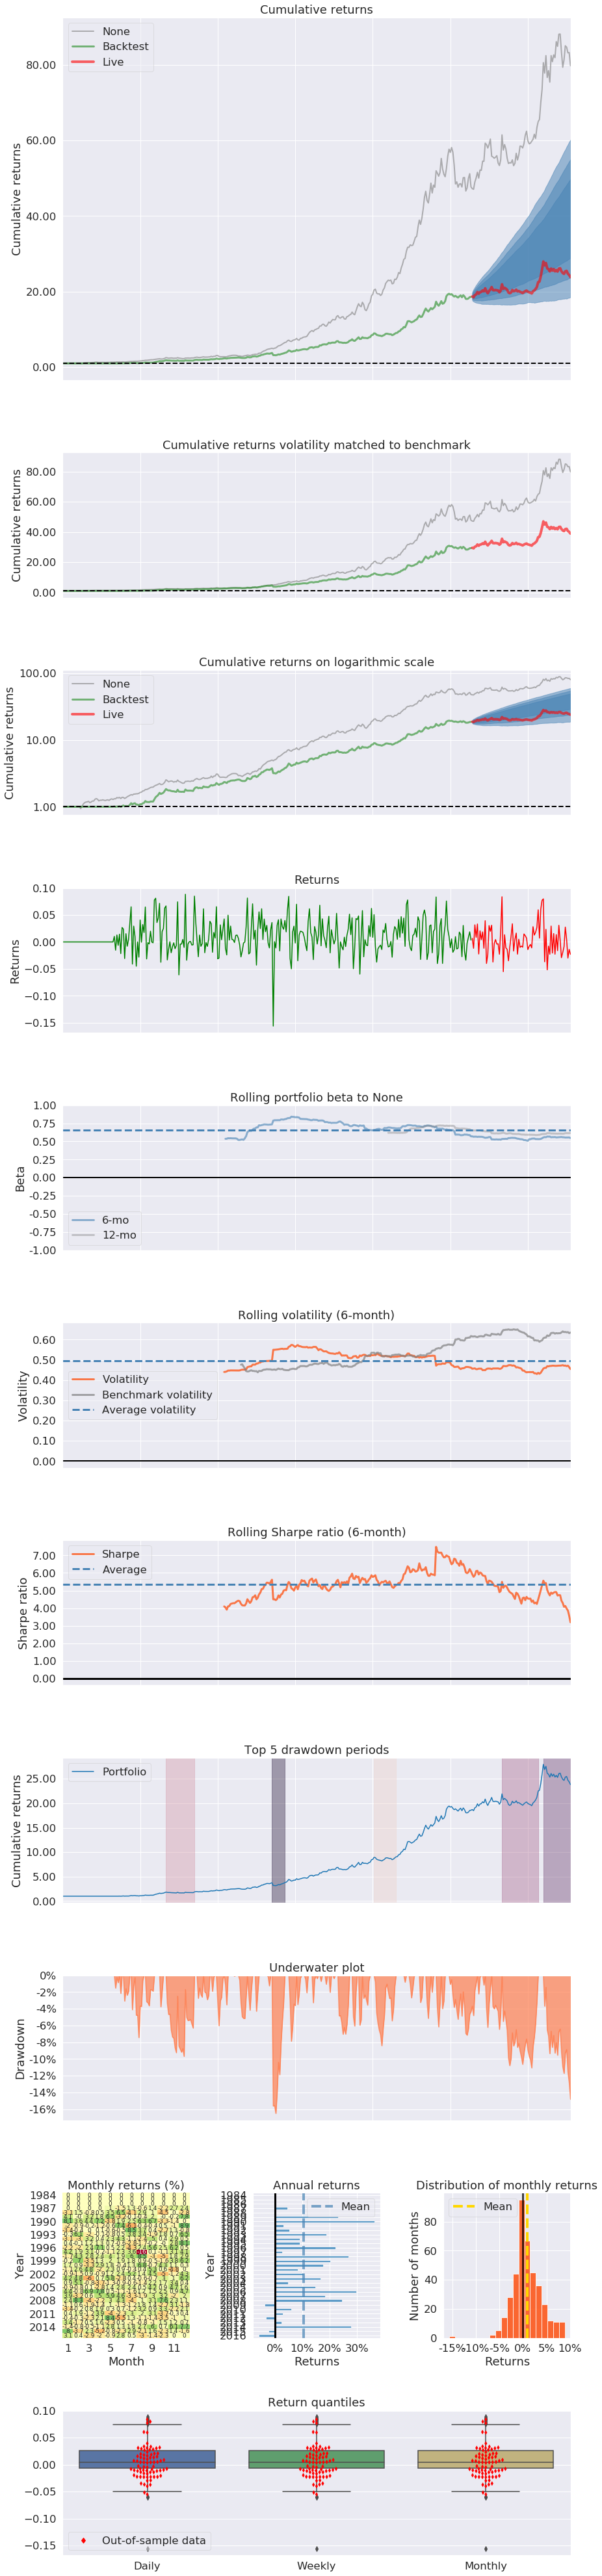

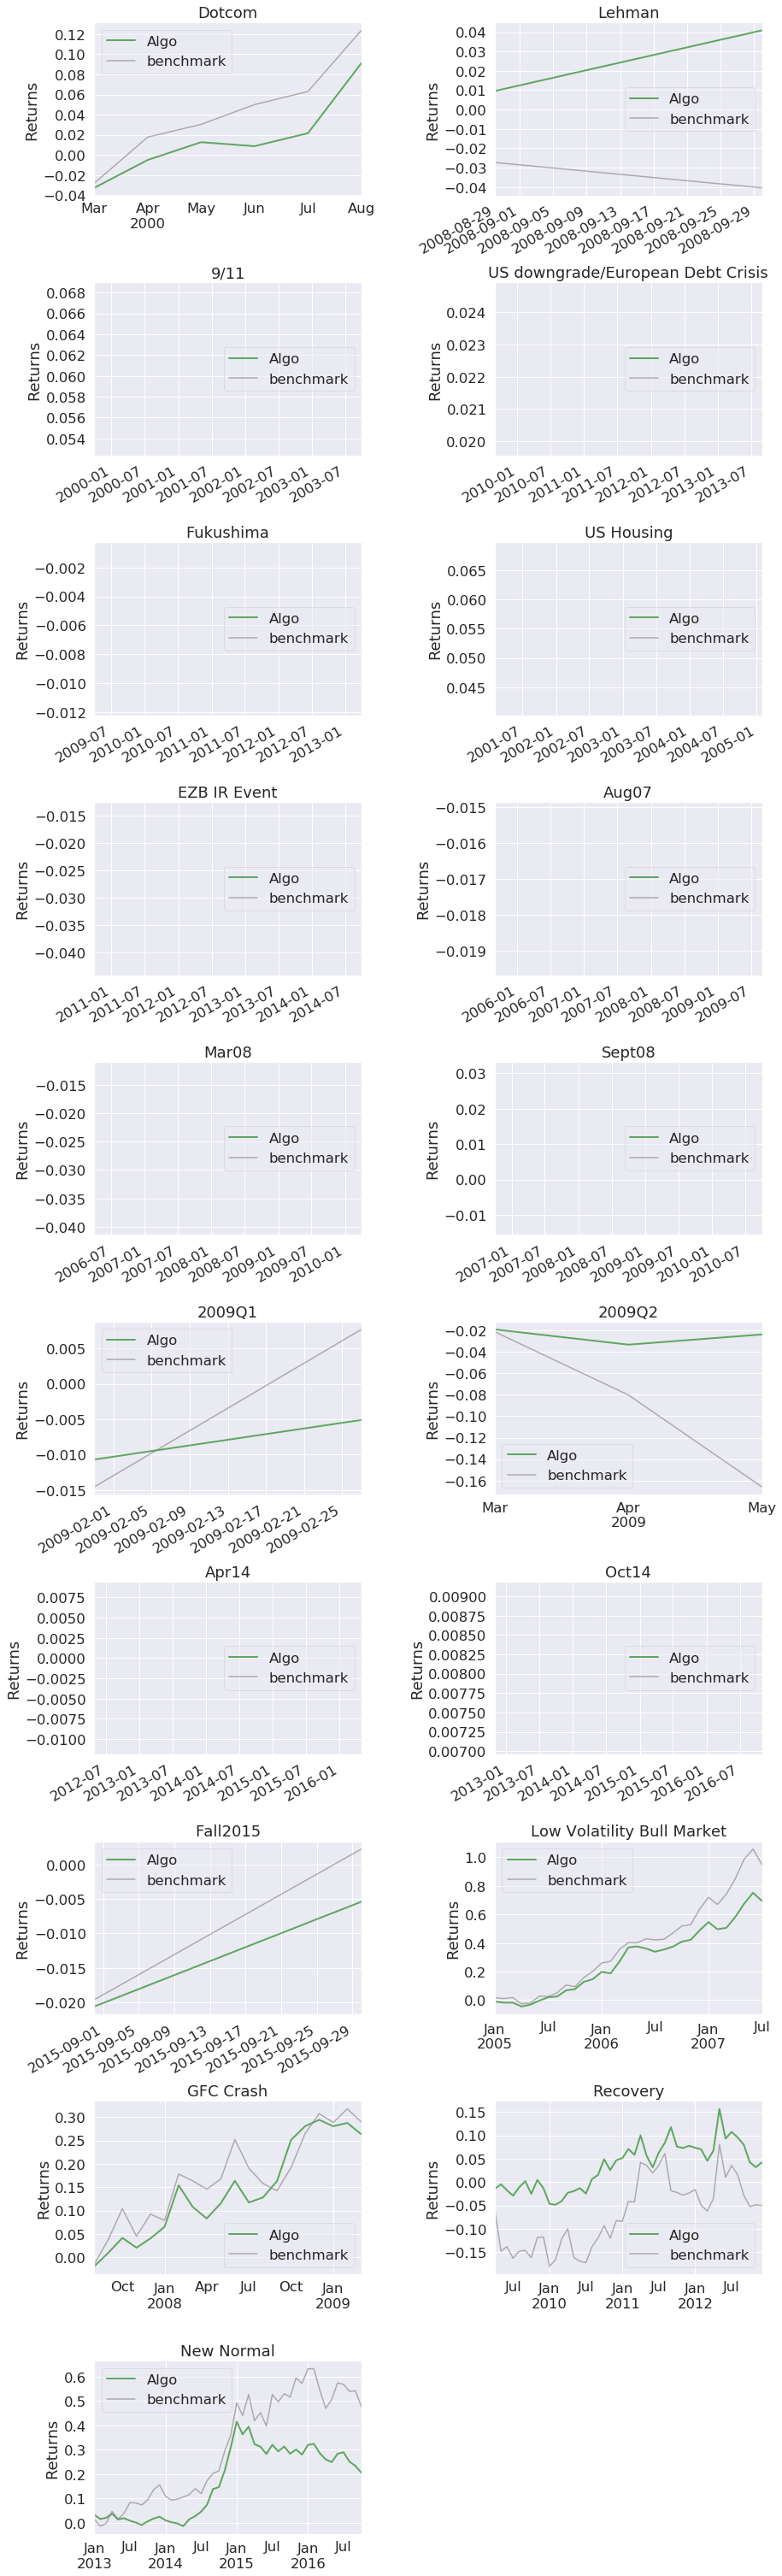

In [24]:
##############################################Evaluating equity curve#################################################   
avg_ret_stream_costs.index = avg_ret_stream_costs.index.tz_localize('US/Eastern')
portfolio_monthly_returns_opt.index = avg_ret_stream_costs.index

pf.create_full_tear_sheet(portfolio_monthly_returns_opt, benchmark_rets=avg_ret_stream_costs, live_start_date = '2010-06-07') 
